In [20]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml 

# Load & prepare web logs (dw)

# 1. Extract the web log ZIP file
# 2. Load all .txt files and concatenate into dw
# 3. Merge Variation (Test/Control) from experiment file
# 4. Merge client age from demo file

# Paths to input files
# ZIP_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_web_data_pt_.zip"
# EXPERIMENT_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_experiment_clients.txt"
# DEMO_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_demo.txt"
# EXTRACT_DIR = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/webdata_extracted"

try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

EXP_PATH = config['input_data']['file2']
DEMO_PATH = config['input_data']['file1']
ZIP_PATH  = config['input_data']['file5']
EXTRACT_DIR = "../data/raw/rawwebdata_extracted"



In [21]:

# Extract ZIP
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# Load and concatenate all .txt files
web_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".txt")]
frames = [
    pd.read_csv(os.path.join(EXTRACT_DIR, f), parse_dates=["date_time"]) 
    for f in web_files
]
dw = pd.concat(frames, ignore_index=True)
print(f"✅ Loaded web logs: {len(dw):,} rows from {len(web_files)} files")
print("Columns in dw (before merge):", dw.columns.tolist())

# Merge Variation (CSV file)
exp_clients = pd.read_csv(EXP_PATH, sep=",")
print("Columns in exp_clients:", exp_clients.columns.tolist())
exp_clients = exp_clients[["client_id", "Variation"]]
dw = dw.merge(exp_clients, on="client_id", how="inner")
print(f"✅ Variation merged. Unique groups: {dw['Variation'].unique()}")

# Merge client age (CSV file)

df_demo = pd.read_csv(DEMO_PATH, sep=",")
print("Columns in df_demo:", df_demo.columns.tolist())
df_demo = df_demo[["client_id", "clnt_age"]]
dw = dw.merge(df_demo, on="client_id", how="left")
print(f"✅ Age merged. Non-null ages: {dw['clnt_age'].notna().sum():,}")
print("Columns in dw (final):", dw.columns.tolist()[:10], "...")
print(dw.head(3))
# Define process steps in correct order
STEP_ORDER = ["start", "step_1", "step_2", "step_3", "confirm"]
def compute_visit_durations(df):
    """
    Compute time spent between each step for each visit.
    Each row in the result corresponds to one visit,
    with columns showing time differences in minutes between steps.
    """
    # Sort by visit and timestamp to ensure chronological order
    df_sorted = df.sort_values(["visit_id", "date_time"])
    records = []
    for visit_id, grp in df_sorted.groupby("visit_id"):
        grp = grp.sort_values("date_time")
        times = grp["date_time"].values
        steps = grp["process_step"].values
        # Create a dictionary to store each visit's step durations
        d = {"visit_id": visit_id}
        # Loop through consecutive steps and compute time deltas in minutes
        for i in range(1, len(steps)):
            prev_step = steps[i - 1]
            curr_step = steps[i]
            delta_min = (times[i] - times[i - 1]) / np.timedelta64(1, "m")
            d[f"t_{prev_step}_to_{curr_step}"] = delta_min
        # Compute total duration from start to confirm (if both exist)
        if "start" in steps and "confirm" in steps:
            t_total = (
                grp.loc[grp["process_step"] == "confirm", "date_time"].values[0]
                - grp.loc[grp["process_step"] == "start", "date_time"].values[0]
            ) / np.timedelta64(1, "m")
            d["t_start_to_confirm"] = t_total
        records.append(d)
    # Return a DataFrame with one row per visit and step durations as columns
    return pd.DataFrame(records)
# Split the dataset into exclusive Test and Control groups
dw_test_excl = dw[dw["Variation"] == "Test"].copy()
dw_ctrl_excl = dw[dw["Variation"] == "Control"].copy()
# Compute the per-visit durations for both groups
per_visit_test = compute_visit_durations(dw_test_excl)
per_visit_ctrl = compute_visit_durations(dw_ctrl_excl)
# Show summary of results
print(":white_tick: Visits (Test):", per_visit_test["visit_id"].nunique())
print(":white_tick: Visits (Control):", per_visit_ctrl["visit_id"].nunique())
print("Columns:", per_visit_test.columns.tolist())

def format_mmss(minutes):
    """
    Convert a decimal number of minutes (e.g., 4.25)
    into a readable format mm:ss (e.g., '04:15').
    """
    if pd.isna(minutes):
        return ""
    m = int(minutes)
    s = int(round((minutes - m) * 60))
    return f"{m:02d}:{s:02d}"

#Create age_band column from clnt_age (if not exists)
if "age_band" not in dw.columns:
    # Convert age to numeric (just in case)
    dw["clnt_age"] = pd.to_numeric(dw["clnt_age"], errors="coerce")
    # Remove rows with missing age to avoid NaN groups
    dw = dw[dw["clnt_age"].notna()].copy()
    # Define age bins (10–19, ..., 80+)
    age_bins = list(range(10, 101, 10))
    age_labels = [f"{i}-{i+9}" for i in bins[:-1]]
    # Create categorical age_band column
    dw["age_band"] = pd.cut(
        dw["clnt_age"],
        bins=age_bins,
        labels=age_labels,
        right=False
    )
    print(":white_tick: Age band column created successfully!")
    print(dw[["clnt_age", "age_band"]].head(10))

✅ Loaded web logs: 755,405 rows from 2 files
Columns in dw (before merge): ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time']
Columns in exp_clients: ['client_id', 'Variation']
✅ Variation merged. Unique groups: ['Test' 'Control' nan]
Columns in df_demo: ['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']
✅ Age merged. Non-null ages: 449,704
Columns in dw (final): ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time', 'Variation', 'clnt_age'] ...
   client_id            visitor_id                      visit_id process_step  \
0    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
1    9988021  580560515_7732621733  781255054_21935453173_531117       step_2   
2    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   

            date_time Variation  clnt_age  
0 2017-04-17 15:27:07      Test      79.0  
1 2017-04-17 15:26:51      Tes

In [ ]:
#dw

In [5]:
# 1: Define process step order

# Map each step to a numeric order, so we can detect when a user moves BACKWARD (from step_2 to step_1).

step_order = {
    "start": 0,
    "step_1": 1,
    "step_2": 2,
    "step_3": 3,
    "confirm": 4
}

In [6]:
# 2: Function to count backward moves per visit

# For each visit (visit_id):
# 1. Sort events by date_time
# 2. Map steps to numeric order
# 3. Count decreases in the sequence (backward moves)

def count_backward_moves(df_visit):
    df_visit = df_visit.sort_values("date_time")
    step_nums = df_visit["process_step"].map(step_order).dropna().tolist()
    backward_moves = sum(
        1 for i in range(1, len(step_nums)) if step_nums[i] < step_nums[i - 1]
    )
    return backward_moves

In [7]:
# 3: Count backward moves for each visit

# Group by visit_id and Variation (Test/Control) to count how many backward moves each visit has.

error_counts = (
    dw.groupby(["visit_id", "Variation"])
    .apply(count_backward_moves, include_groups=False)
    .reset_index(name="num_backward_moves")
)

# whether the visit had at least one backward move
# error_counts_age["had_error"] = error_counts_age["num_backward_moves"] > 0
error_counts["had_error"] = error_counts["num_backward_moves"] > 0


In [ ]:
#error_counts

In [8]:
# 4: Error rate summary by group

# - Average number of backward moves per visit
# - Share of visits with at least one backward move

# Average number of backward moves per visit
error_rate_by_group = (
    error_counts.groupby("Variation")["num_backward_moves"]
    .mean()
    .reset_index(name="avg_backward_moves_per_visit")
)

# Share of visits with at least one backward move
error_counts["had_error"] = error_counts["num_backward_moves"] > 0
error_share_by_group = (
    error_counts.groupby("Variation")["had_error"]
    .mean()
    .reset_index(name="share_visits_with_error")
)

print("=== Error rate summary by group (Test vs Control) ===")
display(error_rate_by_group)
display(error_share_by_group)

=== Error rate summary by group (Test vs Control) ===


Variation  avg_backward_moves_per_visit
0   Control                      0.300115
1      Test                      0.439254

Variation  share_visits_with_error
0   Control                 0.204344
1      Test                 0.269571

In [9]:
# 5: Add age bands for age-based analysis

# Assign each visit an age band based on clnt_age.

bins = list(range(10, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]

# Create mapping of visit_id -> age_band
age_map = (
    dw[["visit_id", "clnt_age"]]
    .drop_duplicates()
    .assign(age_band=lambda d: pd.cut(d["clnt_age"], bins=bins, labels=labels, right=False))
)

# Merge age band into error counts
error_counts_age = error_counts.merge(age_map, on="visit_id", how="left")
error_counts_age

visit_id Variation  num_backward_moves  had_error  \
0      100012776_37918976071_457913      Test                   0      False   
1       100019538_17884295066_43909      Test                   2       True   
2      100022086_87870757897_149620      Test                   0      False   
3      100030127_47967100085_936361   Control                   0      False   
4      100037962_47432393712_705583   Control                   1       True   
...                             ...       ...                 ...        ...   
69786  999971096_28827267783_236076      Test                   0      False   
69787  999976049_95772503197_182554      Test                   0      False   
69788  999984454_18731538378_781808      Test                   0      False   
69789  999985675_64610694964_443659   Control                   0      False   
69790  999988789_76411676596_272843      Test                   2       True   

       clnt_age age_band  
0          59.5    50-59  
1          23.5    20-29  
2          47.0    40-49  
3          35.0    30-39  
4          78.0    70-79  
...         ...      ...  
69786      28.5    20-29  
69787      53.5    50-59  
69788      84.5    80-89  
69789      64.5    60-69  
69790      58.0    50-59  

[69791 rows x 6 columns]

In [10]:
# 6: Error rate by age band & group — with formatted outputs

# For each (Variation, age_band):
# - Average number of backward moves per visit
# - Share of visits with at least one backward move

error_rate_by_age = (
    error_counts_age.groupby(["Variation", "age_band"], observed=True)["num_backward_moves"]
    .mean()
    .reset_index(name="avg_backward_moves_per_visit")
)

error_share_by_age = (
    error_counts_age.groupby(["Variation", "age_band"], observed=True)["had_error"]
    .mean()
    .reset_index(name="share_visits_with_error")
)

# Merge the two summaries for convenience
error_summary_by_age = error_rate_by_age.merge(
    error_share_by_age,
    on=["Variation", "age_band"],
    how="left"
)

# --- Formatting section ---
# Round numeric values for analysis
error_summary_by_age["avg_backward_moves_per_visit"] = (
    error_summary_by_age["avg_backward_moves_per_visit"].round(3)
)
error_summary_by_age["share_visits_with_error"] = (
    error_summary_by_age["share_visits_with_error"].round(3)
)

# Add formatted string columns for display
error_summary_by_age["avg_backward_moves_per_visit_fmt"] = (
    error_summary_by_age["avg_backward_moves_per_visit"]
    .apply(lambda x: f"{x*100:.1f}%")
)

error_summary_by_age["share_visits_with_error_fmt"] = (
    error_summary_by_age["share_visits_with_error"]
    .apply(lambda x: f"{x*100:.1f}%")
)

# --- Final display ---
print("=== Error Summary by Age Band & Group ===")
display(error_summary_by_age)


=== Error Summary by Age Band & Group ===


Variation age_band  avg_backward_moves_per_visit  share_visits_with_error  \
0    Control    10-19                         0.324                    0.197   
1    Control    20-29                         0.303                    0.221   
2    Control    30-39                         0.265                    0.192   
3    Control    40-49                         0.289                    0.200   
4    Control    50-59                         0.315                    0.209   
5    Control    60-69                         0.322                    0.210   
6    Control    70-79                         0.314                    0.194   
7    Control    80-89                         0.329                    0.204   
8    Control    90-99                         0.395                    0.263   
9       Test    10-19                         0.348                    0.250   
10      Test    20-29                         0.348                    0.247   
11      Test    30-39                         0.322                    0.232   
12      Test    40-49                         0.389                    0.256   
13      Test    50-59                         0.498                    0.295   
14      Test    60-69                         0.543                    0.294   
15      Test    70-79                         0.585                    0.311   
16      Test    80-89                         0.534                    0.268   
17      Test    90-99                         0.594                    0.375   

   avg_backward_moves_per_visit_fmt share_visits_with_error_fmt  
0                             32.4%                       19.7%  
1                             30.3%                       22.1%  
2                             26.5%                       19.2%  
3                             28.9%                       20.0%  
4                             31.5%                       20.9%  
5                             32.2%                       21.0%  
6                             31.4%                       19.4%  
7                             32.9%                       20.4%  
8                             39.5%                       26.3%  
9                             34.8%                       25.0%  
10                            34.8%                       24.7%  
11                            32.2%                       23.2%  
12                            38.9%                       25.6%  
13                            49.8%                       29.5%  
14                            54.3%                       29.4%  
15                            58.5%                       31.1%  
16                            53.4%                       26.8%  
17                            59.4%                       37.5%

In [ ]:
error_summary_by_age.to_csv("../data/clean/error_by_age_df.csv", index=False)

In [11]:
# 7: Plot error metrics by age band & group (Test vs Control)

import matplotlib.pyplot as plt
import numpy as np

def plot_error_metric(df, value_col, title, ylabel):
    """
    Plot a grouped bar chart for the given error metric.
    - df: error_summary_by_age DataFrame
    - value_col: name of the numeric column to plot
    - title: plot title
    - ylabel: y-axis label
    """
    # Pivot to have Test & Control as columns, age_band as index
    pivot = df.pivot(index="age_band", columns="Variation", values=value_col)
    pivot = pivot.reindex(index=sorted(pivot.index, key=lambda x: str(x)))  # ensure age order

    x = np.arange(len(pivot.index))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(x - width/2, pivot["Test"], width, label="Test")
    ax.bar(x + width/2, pivot["Control"], width, label="Control")

    ax.set_xlabel("Age band")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45, ha="right")
    ax.legend()
    plt.tight_layout()
    plt.show()


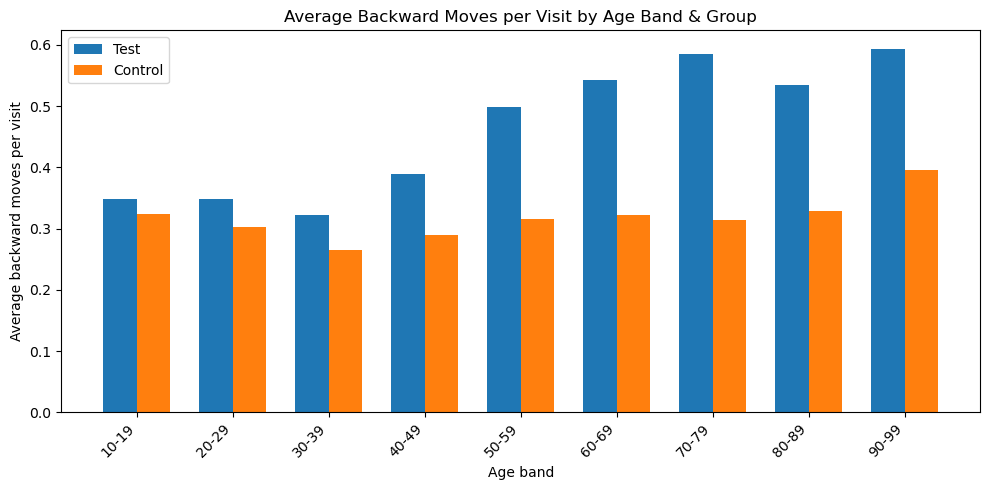

In [12]:
# --- Plot 1: Average backward moves per visit ---
plot_error_metric(
    error_summary_by_age,
    "avg_backward_moves_per_visit",
    "Average Backward Moves per Visit by Age Band & Group",
    "Average backward moves per visit"
)

=== Average Backward Moves per Group ===


Variation  avg_backward_moves_per_visit
0   Control                      0.317333
1      Test                      0.462333

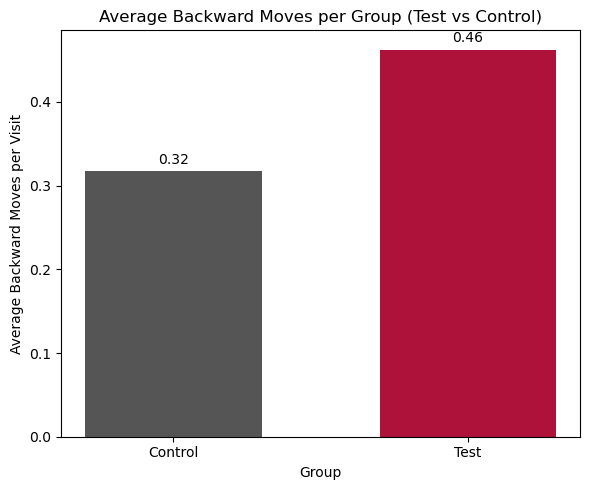

In [13]:
# :one: Compute average backward moves per group
group_summary = (
    error_summary_by_age
    .groupby("Variation", observed=True)["avg_backward_moves_per_visit"]
    .mean()
    .reset_index()
)
print("=== Average Backward Moves per Group ===")
display(group_summary)
# :two: Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(
    group_summary["Variation"],
    group_summary["avg_backward_moves_per_visit"],
    color=["#555555", "#AE123A"],  # gray for Control, Vanguard red for Test
    width=0.6
)
# :three: Add labels and title
ax.set_xlabel("Group")
ax.set_ylabel("Average Backward Moves per Visit")
ax.set_title("Average Backward Moves per Group (Test vs Control)")
# :four: Add value labels on top of bars (2 decimal places)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.005,
            f"{height:.2f}", ha="center", va="bottom", fontsize=10)
# :five: Improve layout and show plot
plt.tight_layout()
plt.show()

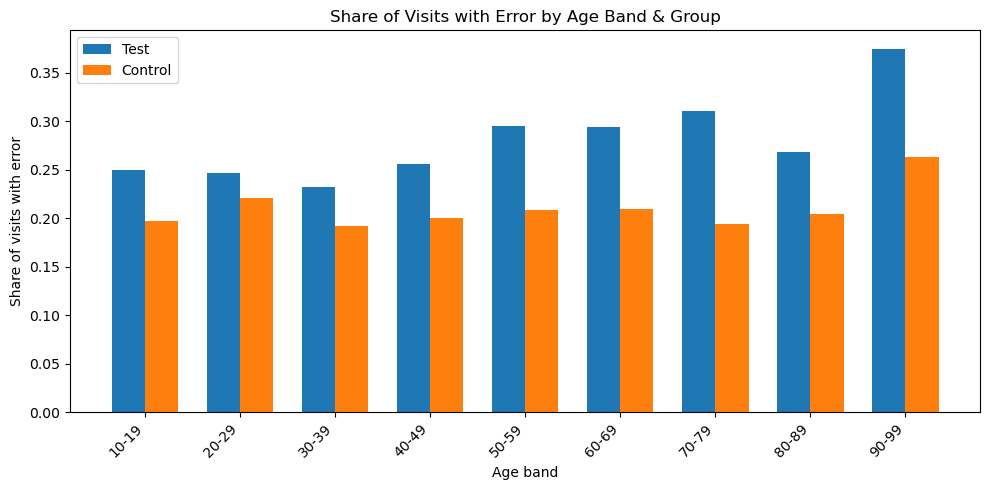

In [14]:
# --- Plot 2: Share of visits with at least one backward move ---
plot_error_metric(
    error_summary_by_age,
    "share_visits_with_error",
    "Share of Visits with Error by Age Band & Group",
    "Share of visits with error"
)

In [15]:
# Separate the data for Test and Control groups-- Two sample test
df_test = error_counts_age.loc[error_counts_age["Variation"] == "Test", "num_backward_moves"]
df_control = error_counts_age.loc[error_counts_age["Variation"] == "Control", "num_backward_moves"]
# Compute sample means
test_mean = df_test.mean()
control_mean = df_control.mean()
# Compute sample standard deviations (ddof=1 for sample std)
test_std = df_test.std(ddof=1)
control_std = df_control.std(ddof=1)
# Sample sizes
n_test = len(df_test)
n_control = len(df_control)
# Compute t-statistic manually
t_statistic = (test_mean - control_mean) / np.sqrt( (test_std**2 / n_test) + (control_std**2 / n_control) )
print(f"t: {t_statistic: .2f}")


t:  22.01


In [ ]:
df_control

In [ ]:
print(f"The mean for test: {test_mean: .2f}")
print(f"The mean for control: {control_mean: .2f}")

In [16]:
def show_statistical_test(statistic: float, alpha: float, n: int, distribution: str=["t-student","normal"], alternative: str=["two-sided","lower","greater"]):
    if distribution not in ["t-student","normal"]:
        raise TypeError("Sorry, only 't-student', and 'normal' distributions are acepted")
    if alternative not in ["two-sided","lower","greater"]:
        raise TypeError("Sorry, only 'two-sided', 'lower', and 'greated' are acepted valued for the alternative")
    if not isinstance(statistic, float):
        raise TypeError("Sorry, the data type for the statistic must be float")
    if not isinstance(alpha, float):
        raise TypeError("Sorry, the data type for alpha must be float")
    if not isinstance(n, int):
        raise TypeError("Sorry, the data type for n must be int")
    x_values = np.linspace(-3, 3)
    if distribution == "t-student":
        y_values = st.t.pdf(x_values, df=n-1)
        if alternative == "two-sided": # Computing the critical values
            lower_critical_value = st.t.ppf(alpha/2, df=n-1)
            upper_critical_value = st.t.ppf(1-(alpha/2), df=n-1)
            x_values1 = np.linspace(-3, lower_critical_value)
            y_values1 = st.t.pdf(x_values1, df=n-1)
            x_values2 = np.linspace(upper_critical_value, 3)
            y_values2 = st.t.pdf(x_values2, df=n-1)
        elif alternative == "lower":
            critical_value = st.t.ppf(alpha, df=n-1)
            x_values1 = np.linspace(-3, critical_value)
            y_values1 = st.t.pdf(x_values1, df=n-1)
        elif alternative == "greater":
            critical_value = st.t.ppf(1-alpha, df=n-1)
            x_values2 = np.linspace(critical_value, 3)
            y_values2 = st.t.pdf(x_values2, df=n-1)
    elif distribution == "normal":
        y_values = st.norm.pdf(x_values)
        if alternative == "two-sided": # Computing the critical values
            lower_critical_value = st.norm.ppf(alpha/2)
            upper_critical_value = st.norm.ppf(1-(alpha/2))
            x_values1 = np.linspace(-3, lower_critical_value)
            y_values1 = st.norm.pdf(x_values1)
            x_values2 = np.linspace(upper_critical_value, 3)
            y_values2 = st.norm.pdf(x_values2)
        elif alternative == "lower":
            critical_value = st.norm.ppf(alpha)
            x_values1 = np.linspace(-3, critical_value)
            y_values1 = st.norm.pdf(x_values1)
        elif alternative == "greater":
            critical_value = st.norm.ppf(1-alpha)
            x_values2 = np.linspace(critical_value, 3)
            y_values2 = st.norm.pdf(x_values2)
    df = pd.DataFrame({"x": x_values, "pdf": y_values})
    title = f"{distribution} Probability Density Function"
    fig = px.line(df, x="x", y="pdf", title=title)
    if alternative == "two-sided":
        fig.add_vline(x=lower_critical_value, line_color="red")
        fig.add_vline(x=upper_critical_value, line_color="red")
        fig.add_annotation(x=lower_critical_value,y=0,text=f"Lower critical value {lower_critical_value: .2f}",xref="x",yref="paper",yanchor="bottom")
        fig.add_annotation(x=upper_critical_value,y=0,text=f"Upper critical value {upper_critical_value: .2f}",xref="x",yref="paper",yanchor="bottom")
        fig.add_scatter(x=x_values1, y=y_values1,fill='tozeroy', mode='none' , fillcolor='red')
        fig.add_scatter(x=x_values2, y=y_values2,fill='tozeroy', mode='none' , fillcolor='red')
    elif alternative == "lower":
        fig.add_vline(x=critical_value, line_color="red")
        fig.add_annotation(x=critical_value,y=0,text=f"Critical value {critical_value: .2f}",xref="x",yref="paper",yanchor="bottom")
        fig.add_scatter(x=x_values1, y=y_values1,fill='tozeroy', mode='none' , fillcolor='red')
    elif alternative == "greater":
        fig.add_vline(x=critical_value, line_color="red")
        fig.add_annotation(x=critical_value,y=0,text=f"Critical value {critical_value: .2f}",xref="x",yref="paper",yanchor="bottom")
        fig.add_scatter(x=x_values2, y=y_values2,fill='tozeroy', mode='none' , fillcolor='red')
    fig.add_vline(x=statistic)
    fig.add_annotation(x=statistic,y=0,text=f"Statistic {statistic: .2f}",xref="x",yref="paper",yanchor="bottom")
    fig.update_layout(title_text=f'{distribution} Probability Density Function', title_x=0.5)
    fig.update_layout(showlegend=False)
    fig.show()

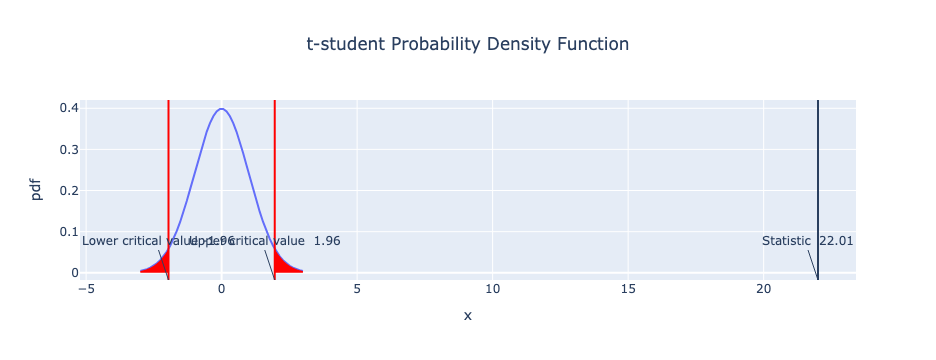

In [17]:
import scipy.stats as st
import plotly.express as px
show_statistical_test(t_statistic, 0.05, n_test+n_control-2, distribution="t-student", alternative="two-sided")

=== Completion Rates by Step and Group ===


Variation  n_start  n_completed     step  completion_rate
0   Control    25902        25902    start           100.00
1      Test    28726        28726    start           100.00
2   Control    25902        21228   step_1            81.96
3      Test    28726        25544   step_1            88.92
4   Control    25902        19159   step_2            73.97
5      Test    28726        22969   step_2            79.96
6   Control    25902        17693   step_3            68.31
7      Test    28726        21264   step_3            74.02
8   Control    25902        15560  confirm            60.07
9      Test    28726        19499  confirm            67.88

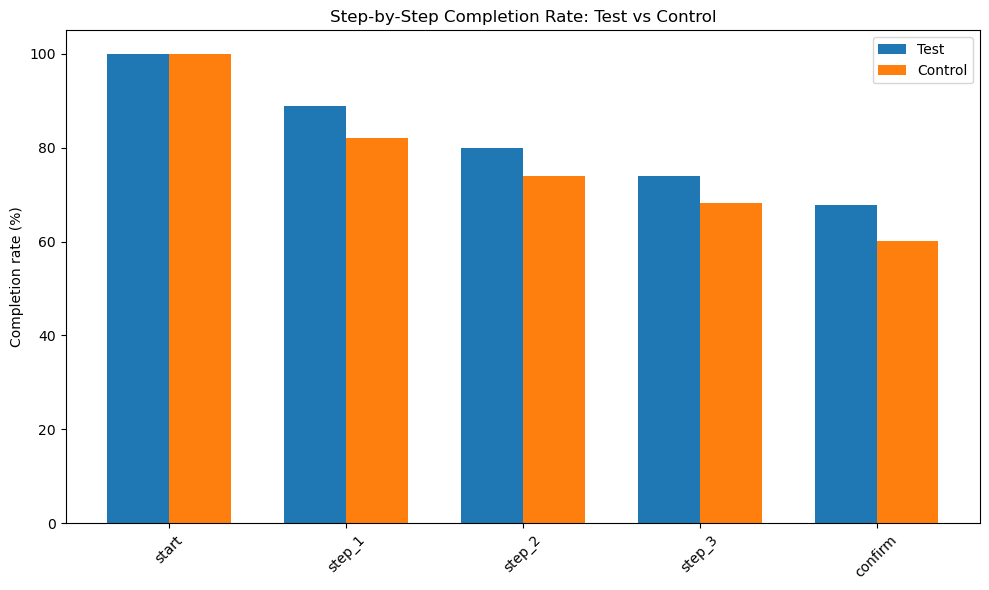

=== Global Completion Rate (Start → Confirm) ===


Variation  n_start  n_completed     step  completion_rate
8   Control    25902        15560  confirm            60.07
9      Test    28726        19499  confirm            67.88

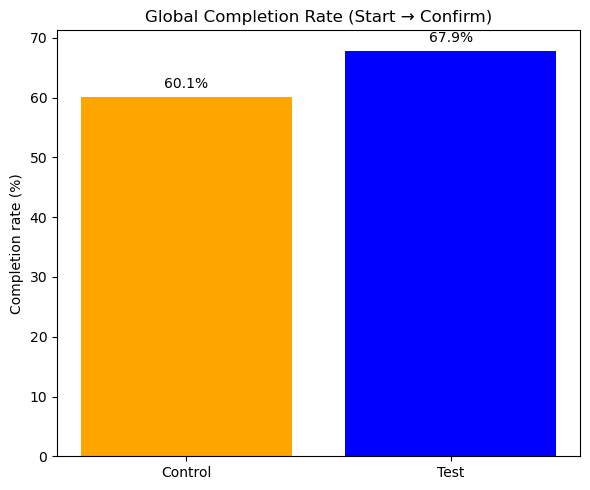

In [18]:
# ==========================================================
# 1) Define the funnel steps in logical order
# ==========================================================
STEP_ORDER = ["start", "step_1", "step_2", "step_3", "confirm"]
# ==========================================================
# 2) Function to compute completion rates for each group
# ==========================================================
def compute_completion_rates(df):
    """
    Computes completion rates (as %) for each step in STEP_ORDER
    separately for Test and Control groups.
    Returns a DataFrame with Variation, step, n_completed, n_start, and completion_rate.
    """
    # Number of unique visitors who started, by group
    start_counts = (
        df[df["process_step"] == "start"]
        .groupby("Variation")["visitor_id"]
        .nunique()
        .rename("n_start")
    )
    records = []
    for step in STEP_ORDER:
        # Count unique visitors who reached this step
        step_counts = (
            df[df["process_step"] == step]
            .groupby("Variation")["visitor_id"]
            .nunique()
            .rename("n_completed")
        )
        merged = pd.concat([start_counts, step_counts], axis=1)
        merged["step"] = step
        merged["completion_rate"] = (
            merged["n_completed"] / merged["n_start"] * 100
        ).round(2)
        records.append(merged.reset_index())
    return pd.concat(records, ignore_index=True)
# ==========================================================
# 3) Apply function to the main web log DataFrame `dw`
# ==========================================================
completion_rates = compute_completion_rates(dw)
print("=== Completion Rates by Step and Group ===")
display(completion_rates)
# ==========================================================
# 4) Plot completion rate per step - side by side bars
# ==========================================================
def plot_completion_by_step(df):
    """
    Plots side-by-side bars of completion rates for each step by Variation.
    """
    pivot = df.pivot(index="step", columns="Variation", values="completion_rate")
    pivot = pivot.reindex(index=STEP_ORDER)  # keep logical order
    x = range(len(pivot.index))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar([i - width/2 for i in x], pivot["Test"], width, label="Test")
    ax.bar([i + width/2 for i in x], pivot["Control"], width, label="Control")
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45)
    ax.set_ylabel("Completion rate (%)")
    ax.set_title("Step-by-Step Completion Rate: Test vs Control")
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_completion_by_step(completion_rates)
# ==========================================================
# 5) Global completion rate (Start → Confirm)
# ==========================================================
global_completion = completion_rates[completion_rates["step"] == "confirm"].copy()
print("=== Global Completion Rate (Start → Confirm) ===")
display(global_completion)
# ==========================================================
# 6) Plot global completion comparison
# ==========================================================
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(global_completion["Variation"], global_completion["completion_rate"], color=["orange", "blue"])
ax.set_ylabel("Completion rate (%)")
ax.set_title("Global Completion Rate (Start → Confirm)")
for i, val in enumerate(global_completion["completion_rate"]):
    ax.text(i, val + 1, f"{val:.1f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()

In [ ]:
df

In [22]:
# 7) Completion rate by step and age band
# ==========================================================
def compute_completion_by_age(df):
    """
    Computes completion rates per step grouped by (Variation, age_band).
    Returns a DataFrame with Variation, age_band, step, n_completed, n_start, completion_rate.
    """
    records = []
    # Count how many visitors started in each (Variation, age_band)
    start_counts = (
        df[df["process_step"] == "start"]
        .groupby(["Variation", "age_band"],observed =True)["visitor_id"]
        .nunique()
        .rename("n_start")
    )
    for step in STEP_ORDER:
        step_counts = (
            df[df["process_step"] == step]
            .groupby(["Variation", "age_band"], observed = True)["visitor_id"]
            .nunique()
            .rename("n_completed")
        )
        merged = pd.concat([start_counts, step_counts], axis=1)
        merged["step"] = step
        merged["completion_rate"] = (
            merged["n_completed"] / merged["n_start"] * 100
        ).round(2)
        records.append(merged.reset_index())
    return pd.concat(records, ignore_index=True)
completion_by_age = compute_completion_by_age(dw)
print("=== Completion rate by step, group, and age band ===")
display(completion_by_age.head(53))
display(completion_by_age.tail(37))

=== Completion rate by step, group, and age band ===


Variation age_band  n_start  n_completed    step  completion_rate
0    Control    10-19      232          232   start           100.00
1    Control    20-29     4030         4030   start           100.00
2    Control    30-39     4791         4791   start           100.00
3    Control    40-49     4396         4396   start           100.00
4    Control    50-59     5756         5756   start           100.00
5    Control    60-69     4846         4846   start           100.00
6    Control    70-79     1563         1563   start           100.00
7    Control    80-89      285          285   start           100.00
8    Control    90-99       26           26   start           100.00
9       Test    10-19      268          268   start           100.00
10      Test    20-29     4541         4541   start           100.00
11      Test    30-39     5508         5508   start           100.00
12      Test    40-49     4915         4915   start           100.00
13      Test    50-59     6329         6329   start           100.00
14      Test    60-69     5275         5275   start           100.00
15      Test    70-79     1571         1571   start           100.00
16      Test    80-89      321          321   start           100.00
17      Test    90-99       27           27   start           100.00
18   Control    10-19      232          194  step_1            83.62
19   Control    20-29     4030         3359  step_1            83.35
20   Control    30-39     4791         3938  step_1            82.20
21   Control    40-49     4396         3606  step_1            82.03
22   Control    50-59     5756         4713  step_1            81.88
23   Control    60-69     4846         3941  step_1            81.32
24   Control    70-79     1563         1246  step_1            79.72
25   Control    80-89      285          234  step_1            82.11
26   Control    90-99       26           19  step_1            73.08
27      Test    10-19      268          241  step_1            89.93
28      Test    20-29     4541         4084  step_1            89.94
29      Test    30-39     5508         4835  step_1            87.78
30      Test    40-49     4915         4381  step_1            89.14
31      Test    50-59     6329         5620  step_1            88.80
32      Test    60-69     5275         4720  step_1            89.48
33      Test    70-79     1571         1394  step_1            88.73
34      Test    80-89      321          274  step_1            85.36
35      Test    90-99       27           22  step_1            81.48
36   Control    10-19      232          179  step_2            77.16
37   Control    20-29     4030         3116  step_2            77.32
38   Control    30-39     4791         3648  step_2            76.14
39   Control    40-49     4396         3336  step_2            75.89
40   Control    50-59     5756         4302  step_2            74.74
41   Control    60-69     4846         3470  step_2            71.61
42   Control    70-79     1563          932  step_2            59.63
43   Control    80-89      285          184  step_2            64.56
44   Control    90-99       26           11  step_2            42.31
45      Test    10-19      268          228  step_2            85.07
46      Test    20-29     4541         3736  step_2            82.27
47      Test    30-39     5508         4365  step_2            79.25
48      Test    40-49     4915         3978  step_2            80.94
49      Test    50-59     6329         5098  step_2            80.55
50      Test    60-69     5275         4174  step_2            79.13
51      Test    70-79     1571         1166  step_2            74.22
52      Test    80-89      321          232  step_2            72.27

Variation age_band  n_start  n_completed     step  completion_rate
53      Test    90-99       27           19   step_2            70.37
54   Control    10-19      232          167   step_3            71.98
55   Control    20-29     4030         2802   step_3            69.53
56   Control    30-39     4791         3306   step_3            69.00
57   Control    40-49     4396         3053   step_3            69.45
58   Control    50-59     5756         3994   step_3            69.39
59   Control    60-69     4846         3307   step_3            68.24
60   Control    70-79     1563          901   step_3            57.65
61   Control    80-89      285          171   step_3            60.00
62   Control    90-99       26           10   step_3            38.46
63      Test    10-19      268          216   step_3            80.60
64      Test    20-29     4541         3431   step_3            75.56
65      Test    30-39     5508         4018   step_3            72.95
66      Test    40-49     4915         3635   step_3            73.96
67      Test    50-59     6329         4666   step_3            73.72
68      Test    60-69     5275         3982   step_3            75.49
69      Test    70-79     1571         1109   step_3            70.59
70      Test    80-89      321          215   step_3            66.98
71      Test    90-99       27           19   step_3            70.37
72   Control    10-19      232          161  confirm            69.40
73   Control    20-29     4030         2511  confirm            62.31
74   Control    30-39     4791         2978  confirm            62.16
75   Control    40-49     4396         2770  confirm            63.01
76   Control    50-59     5756         3504  confirm            60.88
77   Control    60-69     4846         2782  confirm            57.41
78   Control    70-79     1563          739  confirm            47.28
79   Control    80-89      285          123  confirm            43.16
80   Control    90-99       26            8  confirm            30.77
81      Test    10-19      268          207  confirm            77.24
82      Test    20-29     4541         3291  confirm            72.47
83      Test    30-39     5508         3803  confirm            69.05
84      Test    40-49     4915         3375  confirm            68.67
85      Test    50-59     6329         4225  confirm            66.76
86      Test    60-69     5275         3510  confirm            66.54
87      Test    70-79     1571          930  confirm            59.20
88      Test    80-89      321          172  confirm            53.58
89      Test    90-99       27           12  confirm            44.44

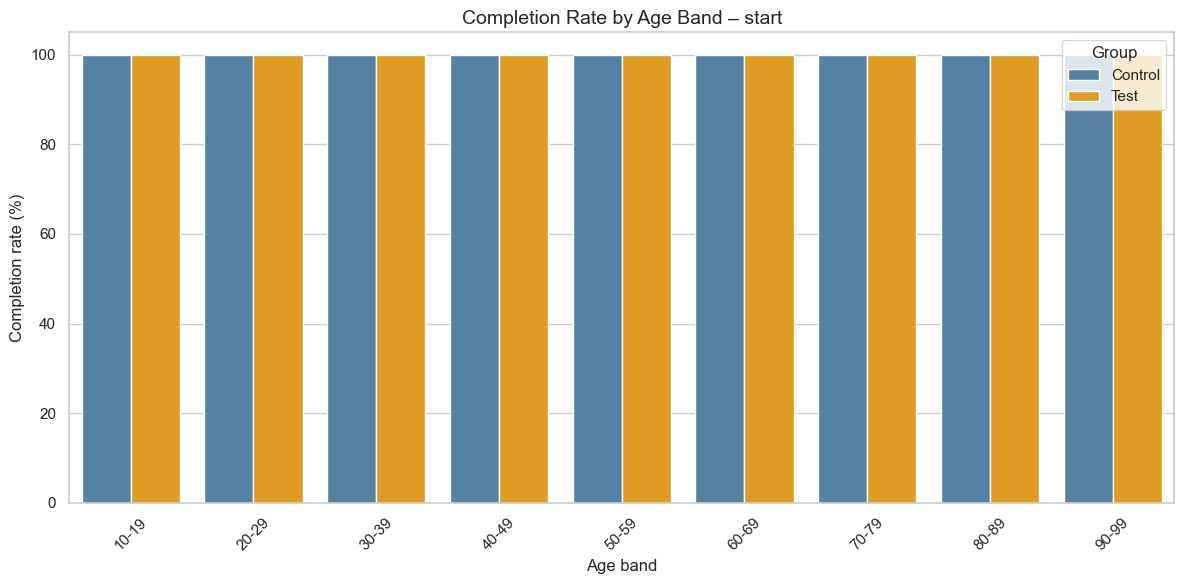

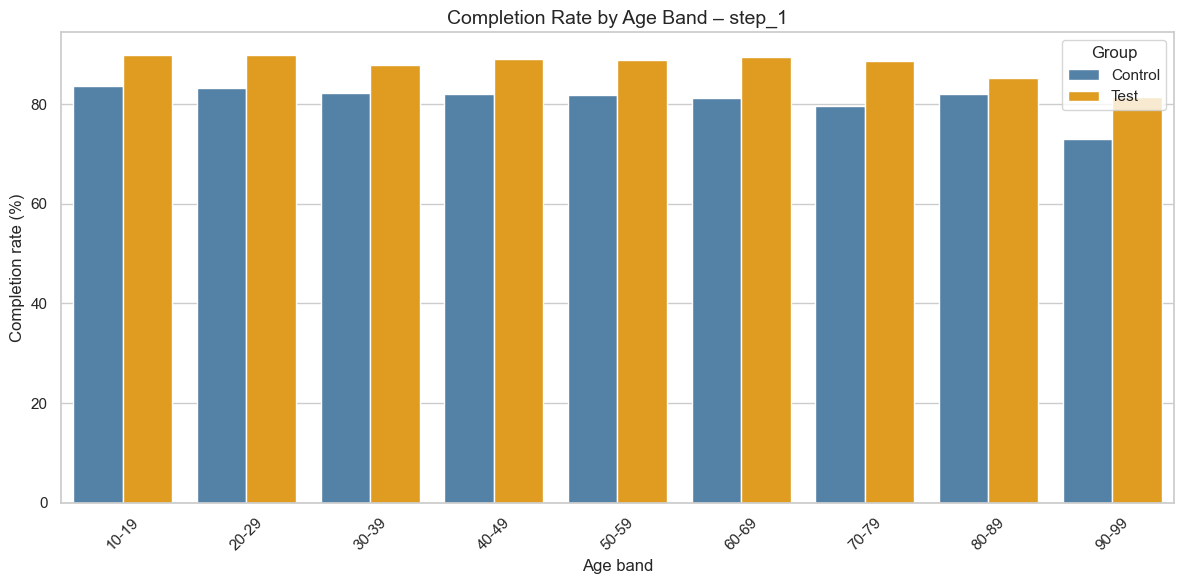

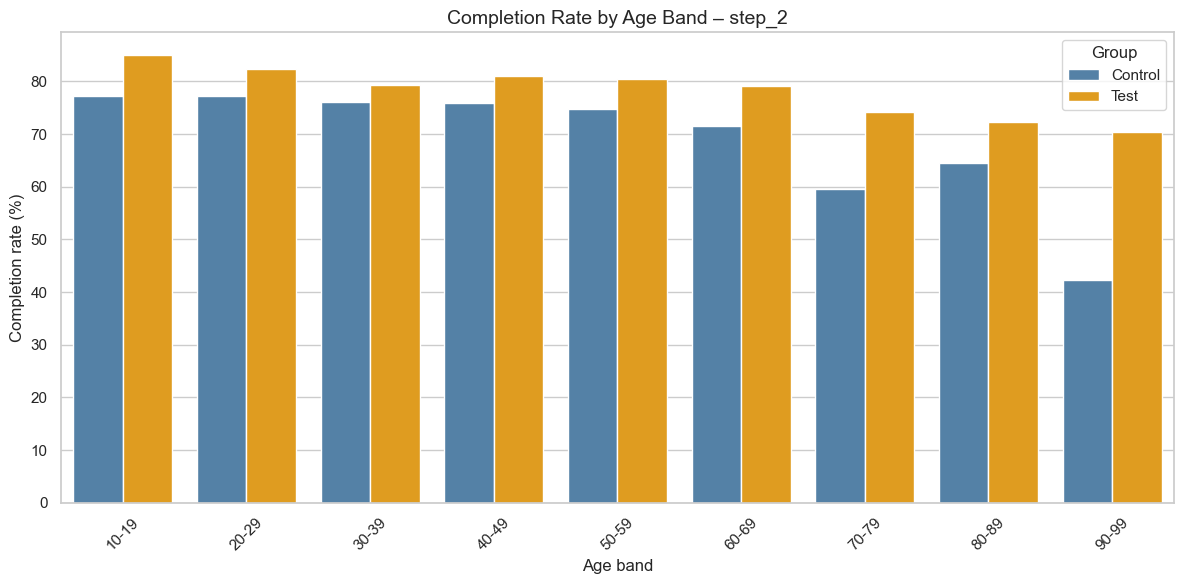

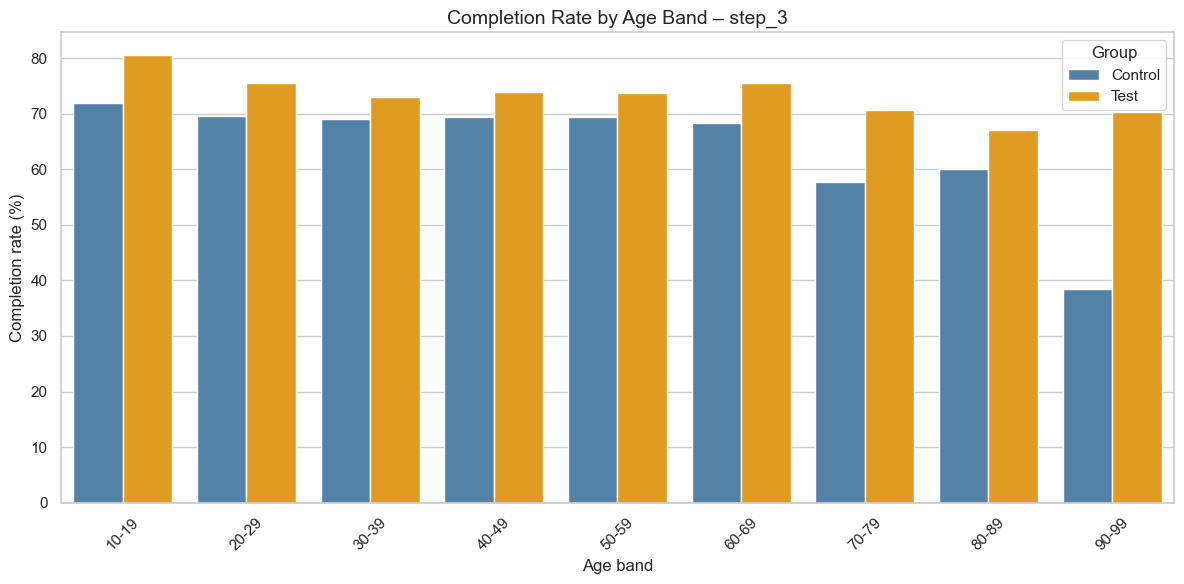

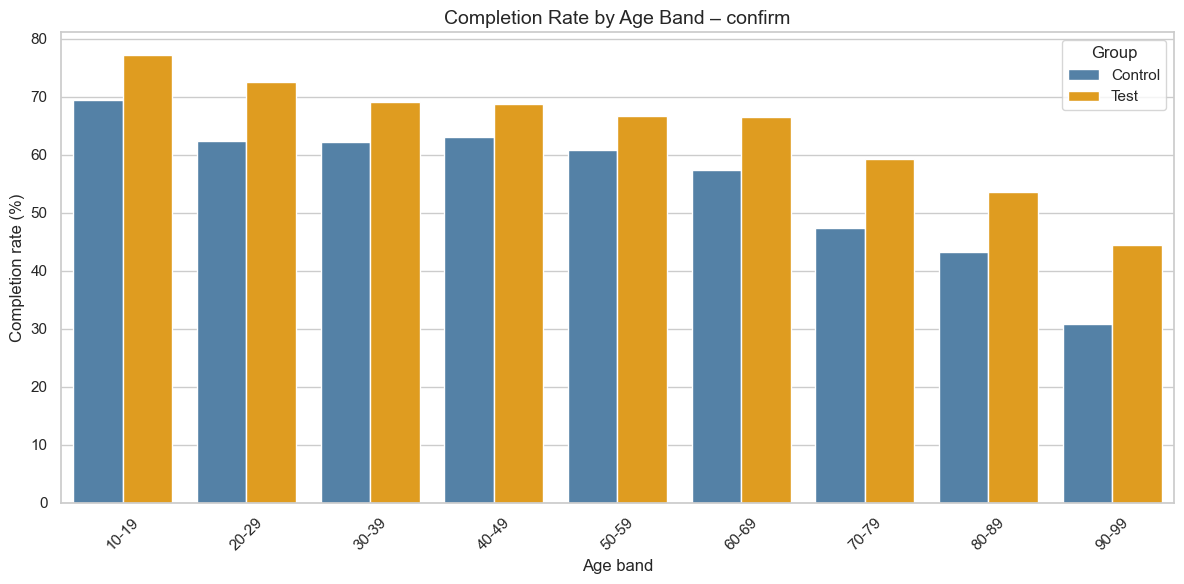

/var/folders/y1/9ww9qd857d59r9rnwfvnykh40000gn/T/ipykernel_75794/728597230.py:37: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



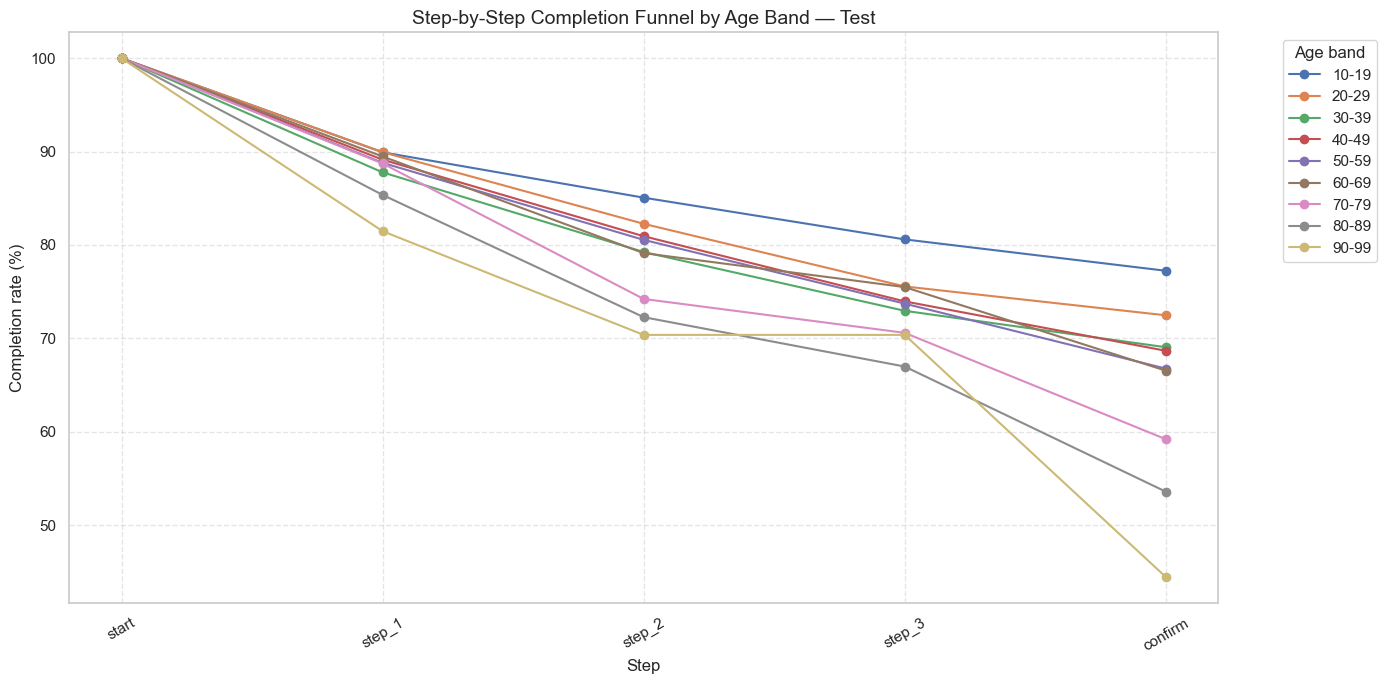

/var/folders/y1/9ww9qd857d59r9rnwfvnykh40000gn/T/ipykernel_75794/728597230.py:37: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



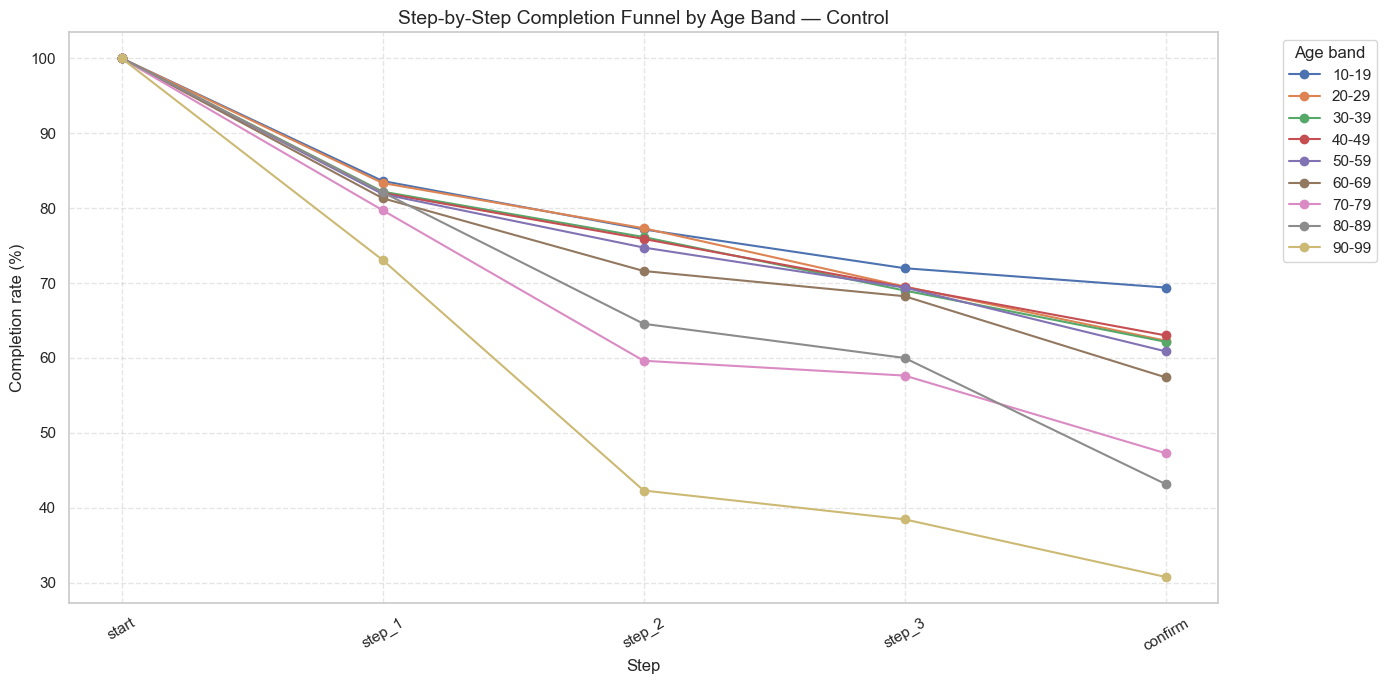

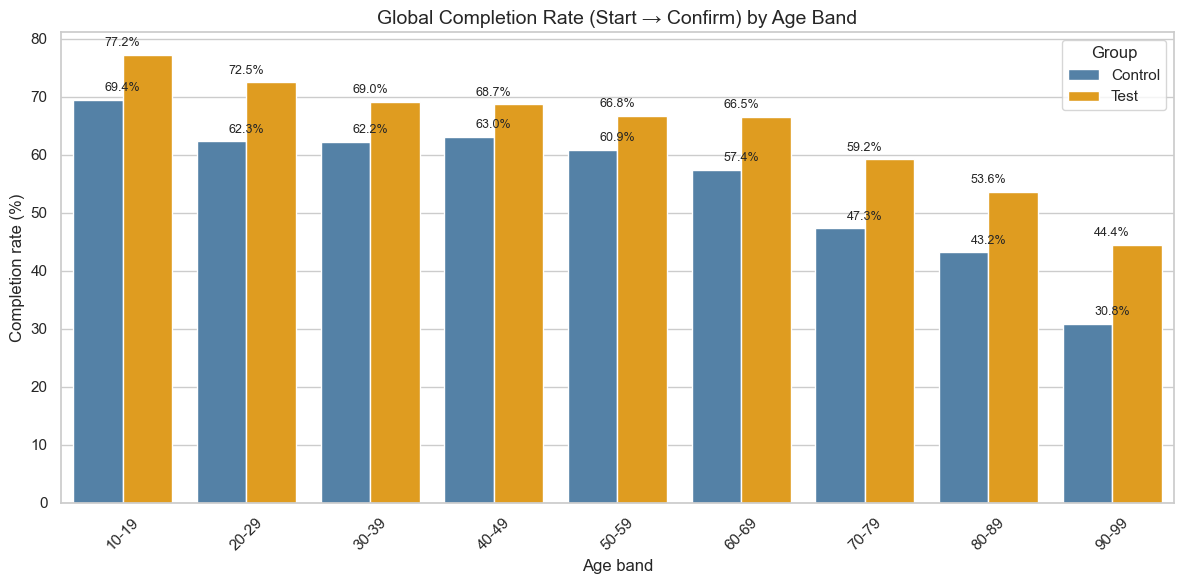

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Make sure we're using Seaborn's style
sns.set(style="whitegrid")
def plot_completion_by_age(df, step):
    """
    Plot completion rates for a specific step, comparing Test vs Control by age band.
    """
    subset = df[df["step"] == step].copy()
    subset = subset.sort_values("age_band")
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=subset,
        x="age_band",
        y="completion_rate",
        hue="Variation",
        palette={"Test":"orange","Control":"steelblue"}
    )
    plt.title(f"Completion Rate by Age Band – {step}", fontsize=14)
    plt.xlabel("Age band")
    plt.ylabel("Completion rate (%)")
    plt.xticks(rotation=45)
    plt.legend(title="Group", loc="best")
    plt.tight_layout()
    plt.show()
# Plot for each step in the funnel
for step in STEP_ORDER:
    plot_completion_by_age(completion_by_age, step)

#This graph shows, for each individual stage, the completion rate by age group—comparing the Test and Control groups side by side.

def plot_funnel_by_age(df, variation):
    """
    Line plot showing step-by-step completion funnel for each age band, within a given Variation group.
    """
    subset = df[df["Variation"] == variation]
    pivot = subset.pivot_table(
        index="step",
        columns="age_band",
        values="completion_rate"
    ).reindex(index=STEP_ORDER)
    plt.figure(figsize=(14,7))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=str(col))
    plt.title(f"Step-by-Step Completion Funnel by Age Band — {variation}", fontsize=14)
    plt.xlabel("Step")
    plt.ylabel("Completion rate (%)")
    plt.xticks(rotation=30)
    plt.legend(title="Age band", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
# Plot funnels for Test and Control separately
plot_funnel_by_age(completion_by_age, "Test")
plot_funnel_by_age(completion_by_age, "Control")

#Here, we've turned the rates per step into a "funnel line," showing how the rate changes from Start → Confirm.

# Filter only the 'confirm' step for the final completion rate
global_by_age = completion_by_age[completion_by_age["step"] == "confirm"].copy()
plt.figure(figsize=(12,6))
sns.barplot(
    data=global_by_age,
    x="age_band",
    y="completion_rate",
    hue="Variation",
    palette={"Test":"orange","Control":"steelblue"}
)
plt.title("Global Completion Rate (Start → Confirm) by Age Band", fontsize=14)
plt.xlabel("Age band")
plt.ylabel("Completion rate (%)")
plt.xticks(rotation=45)
plt.legend(title="Group", loc="best")
# Add value labels on top of bars
for i, row in global_by_age.iterrows():
    plt.text(
        x=i%len(global_by_age["age_band"].unique()),
        y=row["completion_rate"] + 1,
        s=f"{row['completion_rate']:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from math import erf
# --------------------------------------------------------
# Normal cumulative distribution function (CDF)
# Used to calculate p-values for z-test without SciPy
# --------------------------------------------------------
def normal_cdf(z):
    return 0.5 * (1 + erf(z / np.sqrt(2)))
# --------------------------------------------------------
# Two-proportion Z-test (two-sided)
# Compares two proportions (e.g., Test vs Control completion rates)
# --------------------------------------------------------
def two_prop_ztest(x1, n1, x2, n2):
    if n1 == 0 or n2 == 0:
        return np.nan, np.nan
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    # If standard error is zero, handle special cases
    if se == 0:
        if p1 == p2:
            return 0.0, 1.0
        return np.nan, np.nan
    z = (p1 - p2) / se
    p = 2 * (1 - normal_cdf(abs(z)))  # two-sided
    return z, p
# --------------------------------------------------------
# Convert p-value to a significance marker using α = 0.05
# * = significant, ns = not significant
# --------------------------------------------------------
def p_to_star_0_05(p):
    if np.isnan(p):
        return "n/a"
    return "*" if p < 0.05 else "ns"

In [25]:
def ztests_stepwise_overall(completion_rates):
    """
    Run two-proportion Z-tests for each step (Test vs Control),
    using the total number of users who started vs. completed each step.
    """
    test = completion_rates.query("Variation == 'Test'")[["step","n_completed","n_start"]]
    ctrl = completion_rates.query("Variation == 'Control'")[["step","n_completed","n_start"]]
    merged = test.merge(ctrl, on="step", suffixes=("_test","_ctrl"), how="inner")
    out = []
    for _, r in merged.iterrows():
        x1, n1 = int(r["n_completed_test"]), int(r["n_start_test"])
        x2, n2 = int(r["n_completed_ctrl"]), int(r["n_start_ctrl"])
        z, p = two_prop_ztest(x1, n1, x2, n2)
        out.append({
            "step": r["step"],
            "p_test": x1/n1 if n1 else np.nan,
            "p_ctrl": x2/n2 if n2 else np.nan,
            "z_stat": z,
            "p_value": p,
            "sig": p_to_star_0_05(p)
        })
    return pd.DataFrame(out)
# Run stepwise Z-tests (overall)
z_overall = ztests_stepwise_overall(completion_rates)
print("=== Stepwise Z-tests (α=0.05) ===")
display(z_overall)

=== Stepwise Z-tests (α=0.05) ===


step    p_test    p_ctrl     z_stat  p_value sig
0    start  1.000000  1.000000   0.000000      1.0  ns
1   step_1  0.889229  0.819551  23.174903      0.0   *
2   step_2  0.799589  0.739673  16.646337      0.0   *
3   step_3  0.740235  0.683075  14.749185      0.0   *
4  confirm  0.678793  0.600726  19.001804      0.0   *

In [26]:
# Filter the 'confirm' step for global completion comparison
z_global = z_overall.loc[z_overall["step"] == "confirm"].copy()
print("=== Global Z-test (Start → Confirm) ===")
display(z_global)

=== Global Z-test (Start → Confirm) ===


step    p_test    p_ctrl     z_stat  p_value sig
4  confirm  0.678793  0.600726  19.001804      0.0   *

In [27]:
def ztests_stepwise_by_age(completion_by_age):
    """
    Run two-proportion Z-tests for each (age_band, step),
    comparing Test vs Control groups.
    """
    test = completion_by_age.query("Variation == 'Test'")[["age_band","step","n_completed","n_start"]]
    ctrl = completion_by_age.query("Variation == 'Control'")[["age_band","step","n_completed","n_start"]]
    merged = test.merge(ctrl, on=["age_band","step"], suffixes=("_test","_ctrl"), how="inner")
    out = []
    for _, r in merged.iterrows():
        x1, n1 = int(r["n_completed_test"]), int(r["n_start_test"])
        x2, n2 = int(r["n_completed_ctrl"]), int(r["n_start_ctrl"])
        z, p = two_prop_ztest(x1, n1, x2, n2)
        out.append({
            "age_band": r["age_band"],
            "step": r["step"],
            "p_test": x1/n1 if n1 else np.nan,
            "p_ctrl": x2/n2 if n2 else np.nan,
            "z_stat": z,
            "p_value": p,
            "sig": p_to_star_0_05(p)
        })
    return pd.DataFrame(out)
# Run the stepwise Z-tests per age band
z_by_age = ztests_stepwise_by_age(completion_by_age)
print("=== Stepwise Z-tests by age band (α=0.05) ===")
display(z_by_age.head(20))

=== Stepwise Z-tests by age band (α=0.05) ===


age_band    step    p_test    p_ctrl     z_stat       p_value sig
0     10-19   start  1.000000  1.000000   0.000000  1.000000e+00  ns
1     20-29   start  1.000000  1.000000   0.000000  1.000000e+00  ns
2     30-39   start  1.000000  1.000000   0.000000  1.000000e+00  ns
3     40-49   start  1.000000  1.000000   0.000000  1.000000e+00  ns
4     50-59   start  1.000000  1.000000   0.000000  1.000000e+00  ns
5     60-69   start  1.000000  1.000000   0.000000  1.000000e+00  ns
6     70-79   start  1.000000  1.000000   0.000000  1.000000e+00  ns
7     80-89   start  1.000000  1.000000   0.000000  1.000000e+00  ns
8     90-99   start  1.000000  1.000000   0.000000  1.000000e+00  ns
9     10-19  step_1  0.899254  0.836207   2.090539  3.656937e-02   *
10    20-29  step_1  0.899361  0.833499   9.002320  0.000000e+00   *
11    30-39  step_1  0.877814  0.821958   7.958442  1.776357e-15   *
12    40-49  step_1  0.891353  0.820291   9.801427  0.000000e+00   *
13    50-59  step_1  0.887976  0.818798  10.787984  0.000000e+00   *
14    60-69  step_1  0.894787  0.813248  11.663206  0.000000e+00   *
15    70-79  step_1  0.887333  0.797185   6.924809  4.365619e-12   *
16    80-89  step_1  0.853583  0.821053   1.085549  2.776786e-01  ns
17    90-99  step_1  0.814815  0.730769   0.730868  4.648599e-01  ns
18    10-19  step_2  0.850746  0.771552   2.269619  2.323070e-02   *
19    20-29  step_2  0.822726  0.773201   5.715107  1.096352e-08   *

In [28]:
import matplotlib.pyplot as plt
import numpy as np
def plot_completion_by_step_with_sig(crates, z_overall, step_order):
    """
    Plot step-by-step completion rates (Test vs Control),
    with significance markers above each step.
    """
    pivot = crates.pivot(index="step", columns="Variation", values="completion_rate").reindex(step_order)
    x = np.arange(len(pivot.index))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2, pivot["Test"], width, label="Test")
    ax.bar(x + width/2, pivot["Control"], width, label="Control")
    # Add significance stars
    star_map = dict(zip(z_overall["step"], z_overall["sig"]))
    for i, step in enumerate(pivot.index):
        sig = star_map.get(step, "")
        y = np.nanmax([pivot.loc[step,"Test"], pivot.loc[step,"Control"]])
        ax.text(i, y + 1.5, sig, ha="center", va="bottom", fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=45)
    ax.set_ylabel("Completion rate (%)")
    ax.set_title("Step-by-Step Completion Rate — Test vs Control (α=0.05)")
    ax.legend()
    plt.tight_layout()
    plt.show()

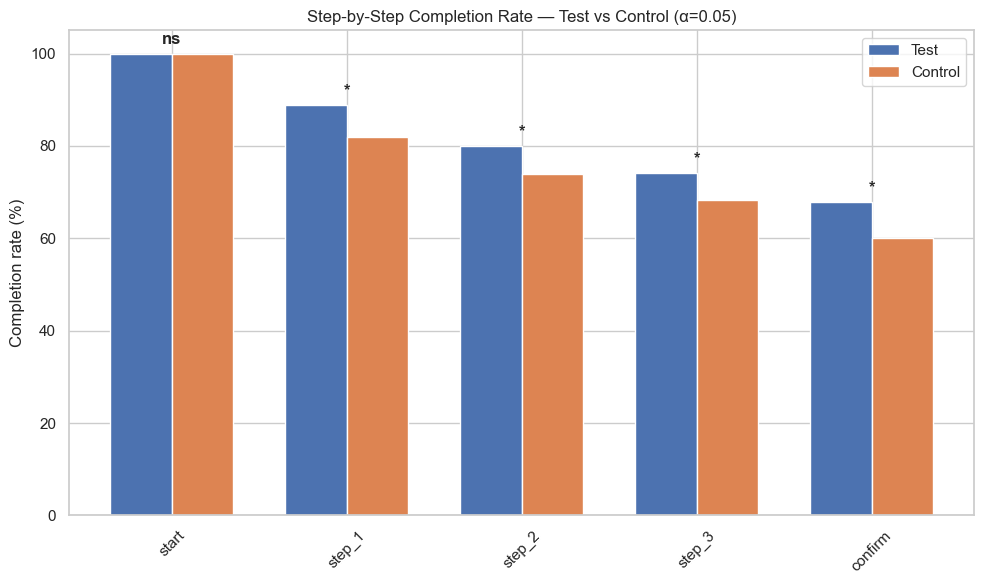

In [29]:
# Plot overall step-by-step completion with significance
plot_completion_by_step_with_sig(completion_rates, z_overall, STEP_ORDER)

/var/folders/y1/9ww9qd857d59r9rnwfvnykh40000gn/T/ipykernel_75794/1874301382.py:20: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



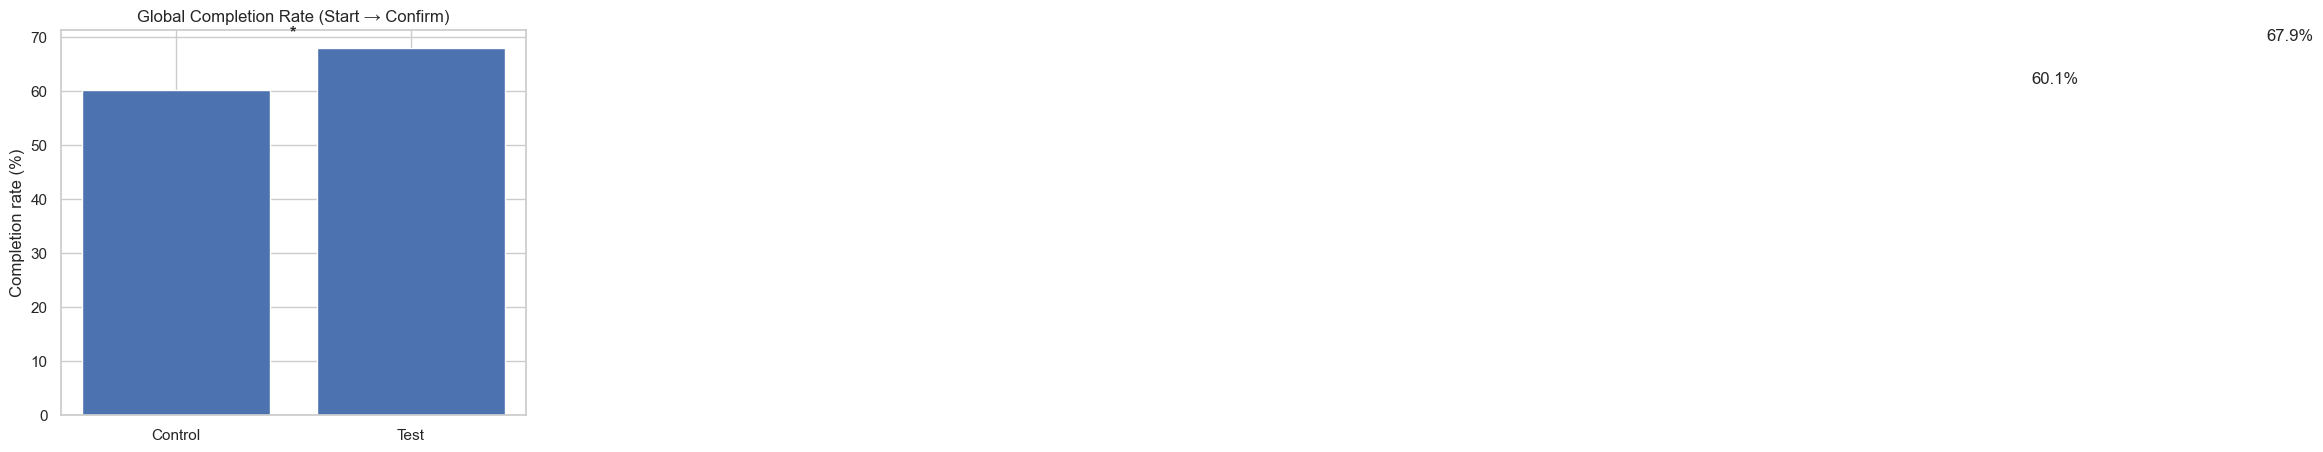

In [30]:
def plot_global_with_sig(crates, z_global):
    """
    Plot global completion rate (Start → Confirm) for Test vs Control,
    with significance annotation above bars.
    """
    sub = crates[crates["step"]=="confirm"].copy()
    fig, ax = plt.subplots(figsize=(6,5))
    ax.bar(sub["Variation"], sub["completion_rate"])
    ax.set_ylabel("Completion rate (%)")
    ax.set_title("Global Completion Rate (Start → Confirm)")
    # Add significance marker
    if not z_global.empty and np.isfinite(z_global["p_value"].iloc[0]):
        sig = z_global["sig"].iloc[0]
        y = sub["completion_rate"].max()
        ax.text(0.5, y + 1.5, sig, ha="center", va="bottom", fontsize=12, fontweight="bold")
    # Add labels on bars
    for i, row in sub.iterrows():
        ax.text(i, row["completion_rate"] + 0.8,
                f"{row['completion_rate']:.1f}%", ha="center", va="bottom")
    plt.tight_layout()
    plt.show()
# Plot global completion Test vs Control
plot_global_with_sig(completion_rates, z_global)

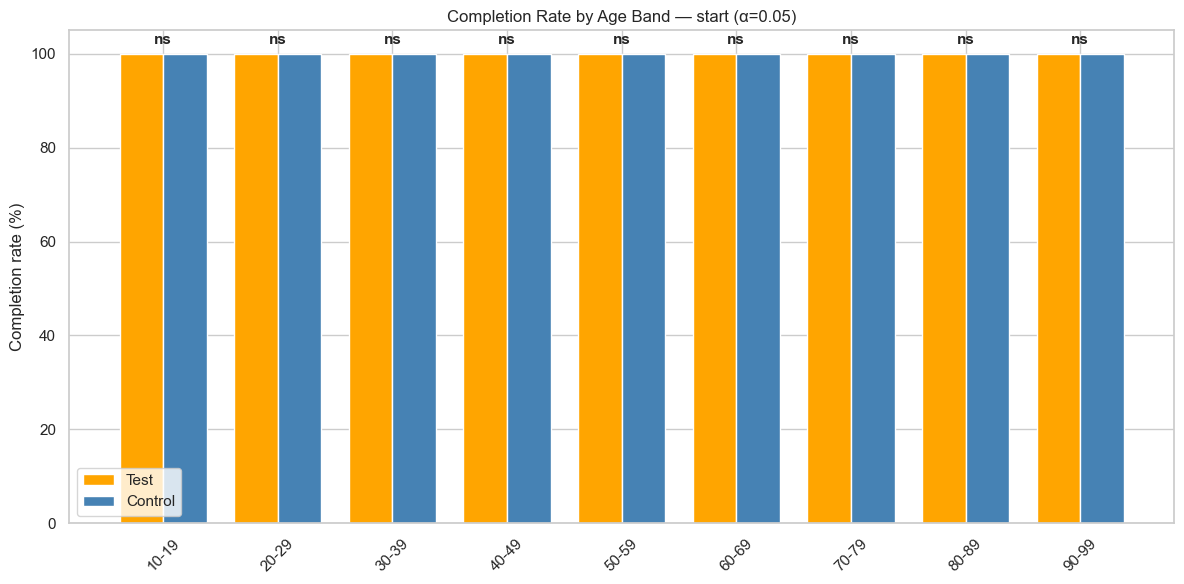

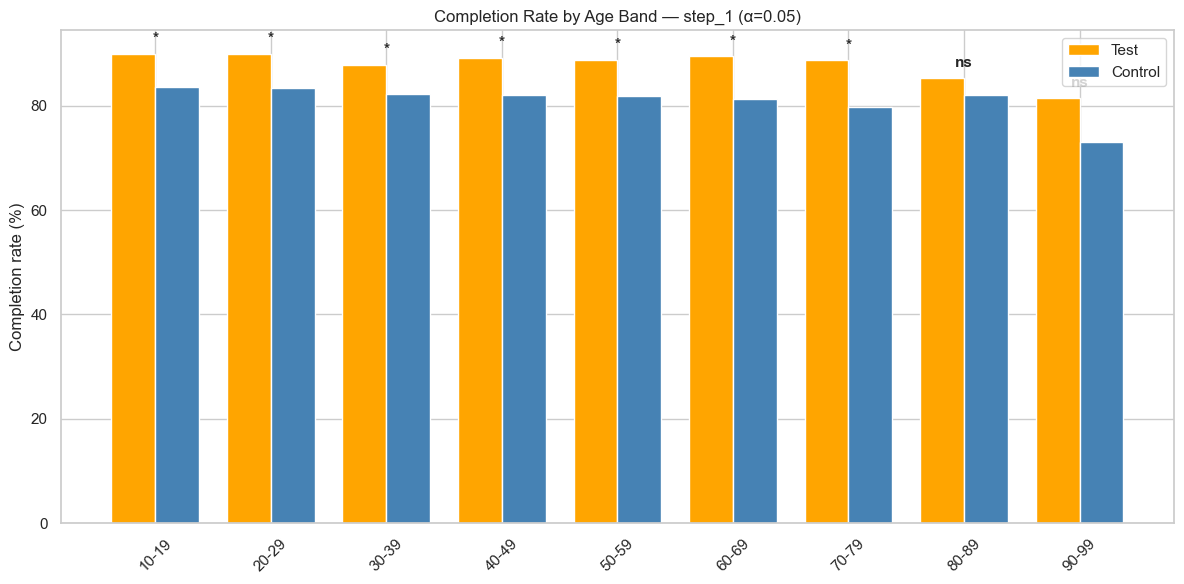

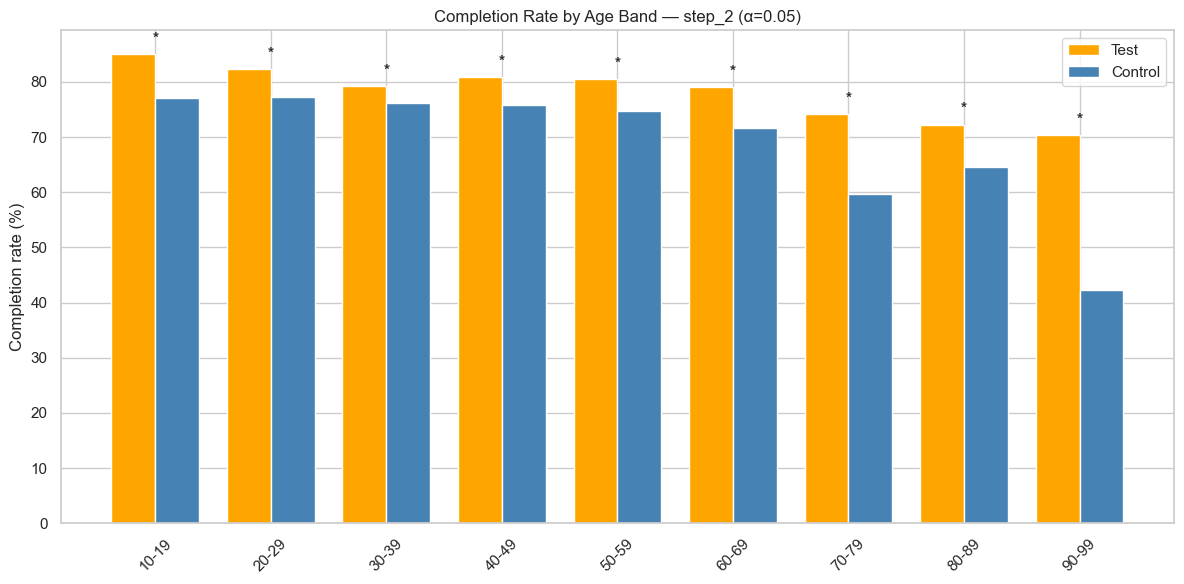

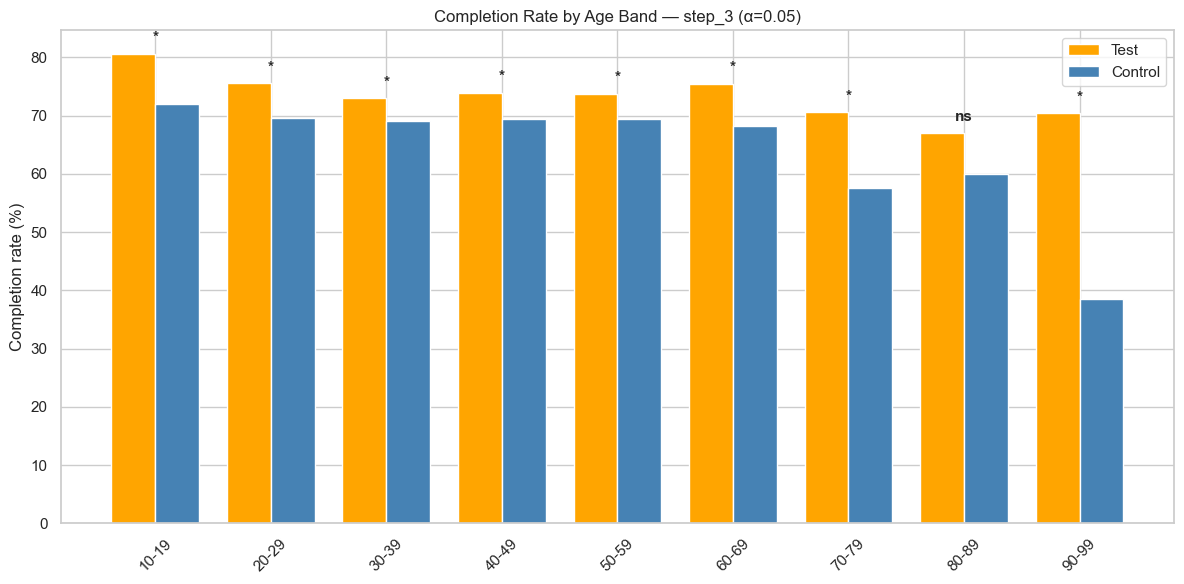

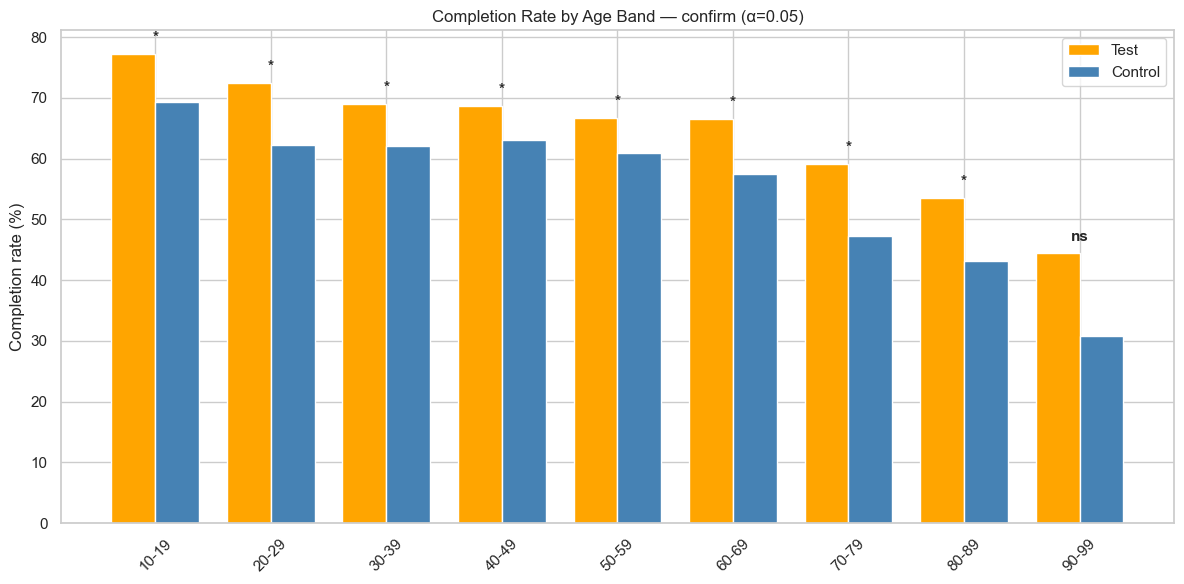

In [31]:
def plot_step_by_age_with_sig(cby_age, z_by_age, step):
    """
    Plot completion rates for a single step,
    broken down by age band and group (Test vs Control),
    with significance markers for each age band.
    """
    sub = cby_age[cby_age["step"]==step].copy()
    age_order = sorted(sub["age_band"].dropna().unique(), key=lambda x: str(x))
    piv = sub.pivot(index="age_band", columns="Variation", values="completion_rate").reindex(age_order)
    x = np.arange(len(age_order))
    width = 0.38
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x - width/2, piv["Test"], width, label="Test", color="orange")
    ax.bar(x + width/2, piv["Control"], width, label="Control", color="steelblue")
    # Add significance markers
    zb = z_by_age[z_by_age["step"]==step].copy()
    star_map = dict(zip(zb["age_band"].astype(str), zb["sig"]))
    for i, band in enumerate(age_order):
        sig = star_map.get(str(band), "")
        y = np.nanmax([piv.loc[band,"Test"], piv.loc[band,"Control"]])
        ax.text(i, y + 1.5, sig, ha="center", va="bottom", fontsize=11, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(age_order, rotation=45)
    ax.set_ylabel("Completion rate (%)")
    ax.set_title(f"Completion Rate by Age Band — {step} (α=0.05)")
    ax.legend()
    plt.tight_layout()
    plt.show()
# Generate a plot per step for all age bands
for step in STEP_ORDER:
    plot_step_by_age_with_sig(completion_by_age, z_by_age, step)

In [32]:
#  Z-tests by Age Band (Step-by-Step)
# ==========================================================
# This block compares Test vs Control completion rates
# for each process step, broken down by age_band.
# It uses two-proportion z-tests (α = 0.05).
# Then it formats the numeric output for better readability.
def ztests_stepwise_by_age(completion_by_age):
    """
    Run two-proportion Z-tests for each (age_band, step),
    comparing Test vs Control groups.
    """
    test = completion_by_age.query("Variation == 'Test'")[["age_band","step","n_completed","n_start"]]
    ctrl = completion_by_age.query("Variation == 'Control'")[["age_band","step","n_completed","n_start"]]
    merged = test.merge(ctrl, on=["age_band","step"], suffixes=("_test","_ctrl"), how="inner")
    out = []
    for _, r in merged.iterrows():
        x1, n1 = int(r["n_completed_test"]), int(r["n_start_test"])
        x2, n2 = int(r["n_completed_ctrl"]), int(r["n_start_ctrl"])
        z, p = two_prop_ztest(x1, n1, x2, n2)
        out.append({
            "age_band": r["age_band"],
            "step": r["step"],
            "p_test": x1/n1 if n1 else np.nan,
            "p_ctrl": x2/n2 if n2 else np.nan,
            "z_stat": z,
            "p_value": p,
            "sig": p_to_star_0_05(p)
        })
    return pd.DataFrame(out)
# Run the stepwise Z-tests per age band
z_by_age = ztests_stepwise_by_age(completion_by_age)
# ==========================================================
# Format numeric columns for clearer visualization
# ==========================================================
z_by_age_fmt = z_by_age.copy()
# Format proportions to 2 decimal places
z_by_age_fmt["p_test"] = z_by_age_fmt["p_test"].map(lambda x: f"{x:.2f}")
z_by_age_fmt["p_ctrl"] = z_by_age_fmt["p_ctrl"].map(lambda x: f"{x:.2f}")
# Format z-statistics to 3 decimal places
z_by_age_fmt["z_stat"] = z_by_age_fmt["z_stat"].map(lambda x: f"{x:.3f}")
# Format p-values: scientific notation if <0.001, else 3 decimal places
z_by_age_fmt["p_value"] = z_by_age_fmt["p_value"].apply(
    lambda x: f"{x:.3e}" if x < 0.001 else f"{x:.3f}"
)
print("=== Stepwise Z-tests by age band (α=0.05, formatted) ===")
display(z_by_age_fmt.head(20))

=== Stepwise Z-tests by age band (α=0.05, formatted) ===


age_band    step p_test p_ctrl  z_stat    p_value sig
0     10-19   start   1.00   1.00   0.000      1.000  ns
1     20-29   start   1.00   1.00   0.000      1.000  ns
2     30-39   start   1.00   1.00   0.000      1.000  ns
3     40-49   start   1.00   1.00   0.000      1.000  ns
4     50-59   start   1.00   1.00   0.000      1.000  ns
5     60-69   start   1.00   1.00   0.000      1.000  ns
6     70-79   start   1.00   1.00   0.000      1.000  ns
7     80-89   start   1.00   1.00   0.000      1.000  ns
8     90-99   start   1.00   1.00   0.000      1.000  ns
9     10-19  step_1   0.90   0.84   2.091      0.037   *
10    20-29  step_1   0.90   0.83   9.002  0.000e+00   *
11    30-39  step_1   0.88   0.82   7.958  1.776e-15   *
12    40-49  step_1   0.89   0.82   9.801  0.000e+00   *
13    50-59  step_1   0.89   0.82  10.788  0.000e+00   *
14    60-69  step_1   0.89   0.81  11.663  0.000e+00   *
15    70-79  step_1   0.89   0.80   6.925  4.366e-12   *
16    80-89  step_1   0.85   0.82   1.086      0.278  ns
17    90-99  step_1   0.81   0.73   0.731      0.465  ns
18    10-19  step_2   0.85   0.77   2.270      0.023   *
19    20-29  step_2   0.82   0.77   5.715  1.096e-08   *

=== Two-sample Z-Test Results: Time per Step (Test vs Control) ===
Metric                          Mean Test  Mean Ctrl     Z-Stat    P-Value
----------------------------------------------------------------------
t_start_to_step_1                    0.52       0.63     -8.704     0.0000
t_step_1_to_step_2                   0.60       0.57      3.845     0.0160
t_step_2_to_step_3                   1.45       1.45     -0.123     0.9231
t_step_3_to_confirm                  1.75       2.12    -12.963     0.0000
t_start_to_confirm                   6.24       6.51     -3.399     0.0279


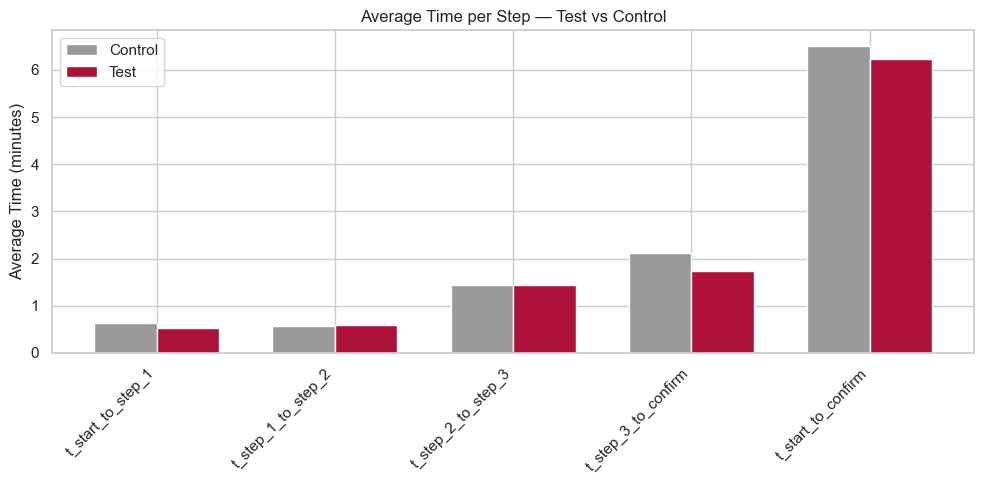

In [33]:
import numpy as np
import matplotlib.pyplot as plt
# ==========================================================
# Function: two-sample z-test using only NumPy
# ==========================================================
def two_sample_ztest(sample1, sample2):
    """
    Perform a two-sample z-test (NumPy only version).
    Returns z_stat and p_value (two-tailed).
    """
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    std1, std2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    n1, n2 = len(sample1), len(sample2)
    # Pooled standard error
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    z_stat = (mean1 - mean2) / se
    # Normal CDF approximation (no scipy)
    def norm_cdf(x):
        return 0.5 * (1 + np.tanh(np.sqrt(np.pi / 8) * x))
    p_value = 2 * (1 - norm_cdf(abs(z_stat)))
    return z_stat, p_value
# ==========================================================
# Step 1: Select all time metrics to test
# ==========================================================
time_metrics = [
    "t_start_to_step_1",
    "t_step_1_to_step_2",
    "t_step_2_to_step_3",
    "t_step_3_to_confirm",
    "t_start_to_confirm"
]
# ==========================================================
# Step 2: Run z-test for each time metric
# ==========================================================
results = []
for metric in time_metrics:
    # Select Test and Control samples
    test_values = per_visit_test[metric].dropna()
    ctrl_values = per_visit_ctrl[metric].dropna()
    z_stat, p_value = two_sample_ztest(test_values, ctrl_values)
    results.append((metric, test_values.mean(), ctrl_values.mean(), z_stat, p_value))
# ==========================================================
# Step 3: Display summary
# ==========================================================
print("=== Two-sample Z-Test Results: Time per Step (Test vs Control) ===")
print(f"{'Metric':30} {'Mean Test':>10} {'Mean Ctrl':>10} {'Z-Stat':>10} {'P-Value':>10}")
print("-"*70)
for metric, m_test, m_ctrl, z, p in results:
    print(f"{metric:30} {m_test:10.2f} {m_ctrl:10.2f} {z:10.3f} {p:10.4f}")
# ==========================================================
# Step 4: Plot the mean times by step
# ==========================================================
metrics = [r[0] for r in results]
means_test = [r[1] for r in results]
means_ctrl = [r[2] for r in results]
x = np.arange(len(metrics))
width = 0.35
plt.figure(figsize=(10,5))
plt.bar(x - width/2, means_ctrl, width, label="Control", color="#9a9a9a")
plt.bar(x + width/2, means_test, width, label="Test", color="#AE123A")
plt.xticks(x, metrics, rotation=45, ha="right")
plt.ylabel("Average Time (minutes)")
plt.title("Average Time per Step — Test vs Control")
plt.legend()
plt.tight_layout()
plt.show()